# Import all the libraries

In [3]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import sys
import time
import torch

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

sys.path.insert(0, "C:/Users/tejru/Downloads/blazeface-pytorch")
from blazeface import BlazeFace


Using TensorFlow backend.


In [46]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import pickle
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image

In [2]:
input_path = 'C:/Users/tejru/Downloads/deepfake-detection-challenge/'
train_dir = glob.glob(input_path + 'train_sample_videos/*.mp4')

In [3]:
df_train = pd.read_json(input_path + 'train_sample_videos/metadata.json').transpose()
df_train.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [4]:
df_train.label.value_counts()

FAKE    323
REAL     77
Name: label, dtype: int64

In [5]:
# Storing video labels in a dictionary
dic = {}
for ind in df_train.index: 
    if(df_train['label'][ind] == 'REAL'):
        dic[ind] = 0
    else:
        dic[ind] = 1

In [17]:
df_train.label.value_counts()

FAKE    323
REAL     77
Name: label, dtype: int64

# Importing the blazeface library from the local host

In [6]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
facedet = BlazeFace().to(gpu)
facedet.load_weights("C:/Users/tejru/Downloads/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("C:/Users/tejru/Downloads/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

# Video reader class converts the video into frames

In [8]:
class VideoReader:
    def __init__(self, verbose=True, insets=(0, 0)):
        self.verbose = verbose
        self.insets = insets

    def read_frames(self, path, num_frames, jitter=0, seed=None):
        assert num_frames > 0
        capture = cv2.VideoCapture(path)
        frame_idxs = np.linspace(90, 90 + num_frames - 1, num_frames, endpoint=True, dtype=np.int)
        if jitter > 0:
            np.random.seed(seed)
            jitter_offsets = np.random.randint(-jitter, jitter, len(frame_idxs))
            frame_idxs = np.clip(frame_idxs + jitter_offsets, 0, frame_count - 1)
        result = self._read_frames_at_indices(path, capture, frame_idxs)
        capture.release()
        return result

    def read_frames_at_indices(self, path, frame_idxs):
        assert len(frame_idxs) > 0
        capture = cv2.VideoCapture(path)
        result = self._read_frames_at_indices(path, capture, frame_idxs)
        capture.release()
        return result

    def _read_frames_at_indices(self, path, capture, frame_idxs):
        try:
            frames = []
            idxs_read = []
            for frame_idx in range(frame_idxs[0], frame_idxs[-1] + 1):
                # Get the next frame, but don't decode if we're not using it.
                ret = capture.grab()
                if not ret:
                    if self.verbose:
                        print("Error grabbing frame %d from movie %s" % (frame_idx, path))
                    break

                # Need to look at this frame?
                current = len(idxs_read)
                if frame_idx == frame_idxs[current]:
                    ret, frame = capture.retrieve()
                    if not ret or frame is None:
                        if self.verbose:
                            print("Error retrieving frame %d from movie %s" % (frame_idx, path))
                        break

                    frame = self._postprocess_frame(frame)
                    frames.append(frame)
                    idxs_read.append(frame_idx)

            if len(frames) > 0:
                return np.stack(frames), idxs_read
            if self.verbose:
                print("No frames read from movie %s" % path)
            return None
        except:
            if self.verbose:
                print("Exception while reading movie %s" % path)
            return None    

    def _postprocess_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if self.insets[0] > 0:
            W = frame.shape[1]
            p = int(W * self.insets[0])
            frame = frame[:, p:-p, :]

        if self.insets[1] > 0:
            H = frame.shape[1]
            q = int(H * self.insets[1])
            frame = frame[q:-q, :, :]

        return frame

## FaceExtractor class is created to cascade the facial features from the images.

In [9]:
class FaceExtractor:
    
    def __init__(self, video_read_fn, facedetn):
        self.video_read_fn = video_read_fn
        self.facedet = facedet
    
    def process_videos(self, input_dir, filenames, video_idxs):
        target_size = self.facedet.input_size

        videos_read = []
        frames_read = []
        frames = []
        tiles = []
        resize_info = []
        for video_idx in video_idxs:
            filename = filenames[video_idx]
            video_path = os.path.join(input_dir, filename)
            result = self.video_read_fn(video_path)
            if result is None: continue

            videos_read.append(video_idx)
            my_frames, my_idxs = result
            frames.append(my_frames)
            frames_read.append(my_idxs)
            my_tiles, my_resize_info = self._tile_frames(my_frames, target_size)
            tiles.append(my_tiles)
            resize_info.append(my_resize_info)
        batch = np.concatenate(tiles)
        all_detections = self.facedet.predict_on_batch(batch, apply_nms=False)

        result = []
        offs = 0
        for v in range(len(tiles)):
            num_tiles = tiles[v].shape[0]
            detections = all_detections[offs:offs + num_tiles]
            offs += num_tiles
            detections = self._resize_detections(detections, target_size, resize_info[v])
            num_frames = frames[v].shape[0]
            frame_size = (frames[v].shape[2], frames[v].shape[1])
            detections = self._untile_detections(num_frames, frame_size, detections)
            detections = self.facedet.nms(detections)

            for i in range(len(detections)):
                faces = self._add_margin_to_detections(detections[i], frame_size, 0.2)
                faces = self._crop_faces(frames[v][i], faces)
                scores = list(detections[i][:, 16].cpu().numpy())
                frame_dict = { "video_idx": videos_read[v],
                               "frame_idx": frames_read[v][i],
                               "frame_w": frame_size[0],
                               "frame_h": frame_size[1],
                               "faces": faces, 
                               "scores": scores }
                result.append(frame_dict)
        return result

    def process_video(self, video_path):
        input_dir = os.path.dirname(video_path)
        filenames = [ os.path.basename(video_path) ]
        return self.process_videos(input_dir, filenames, [0])

    def _tile_frames(self, frames, target_size):
        num_frames, H, W, _ = frames.shape
        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        splits = np.zeros((num_frames * num_v * num_h, target_size[1], target_size[0], 3), dtype=np.uint8)

        i = 0
        for f in range(num_frames):
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    crop = frames[f, y:y+split_size, x:x+split_size, :]
                    splits[i] = cv2.resize(crop, target_size, interpolation=cv2.INTER_AREA)
                    x += x_step
                    i += 1
                y += y_step

        resize_info = [split_size / target_size[0], split_size / target_size[1], 0, 0]
        return splits, resize_info

    def _resize_detections(self, detections, target_size, resize_info):
        projected = []
        target_w, target_h = target_size
        scale_w, scale_h, offset_x, offset_y = resize_info

        for i in range(len(detections)):
            detection = detections[i].clone()

            # ymin, xmin, ymax, xmax
            for k in range(2):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_h - offset_y) * scale_h
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_w - offset_x) * scale_w

            # keypoints are x,y
            for k in range(2, 8):
                detection[:, k*2    ] = (detection[:, k*2    ] * target_w - offset_x) * scale_w
                detection[:, k*2 + 1] = (detection[:, k*2 + 1] * target_h - offset_y) * scale_h

            projected.append(detection)

        return projected    
    
    def _untile_detections(self, num_frames, frame_size, detections):
        combined_detections = []

        W, H = frame_size
        split_size = min(H, W)
        x_step = (W - split_size) // 2
        y_step = (H - split_size) // 2
        num_v = 1
        num_h = 3 if W > H else 1

        i = 0
        for f in range(num_frames):
            detections_for_frame = []
            y = 0
            for v in range(num_v):
                x = 0
                for h in range(num_h):
                    # Adjust the coordinates based on the split positions.
                    detection = detections[i].clone()
                    if detection.shape[0] > 0:
                        for k in range(2):
                            detection[:, k*2    ] += y
                            detection[:, k*2 + 1] += x
                        for k in range(2, 8):
                            detection[:, k*2    ] += x
                            detection[:, k*2 + 1] += y

                    detections_for_frame.append(detection)
                    x += x_step
                    i += 1
                y += y_step

            combined_detections.append(torch.cat(detections_for_frame))

        return combined_detections
    
    def _add_margin_to_detections(self, detections, frame_size, margin=0.2):
        offset = torch.round(margin * (detections[:, 2] - detections[:, 0]))
        detections = detections.clone()
        detections[:, 0] = torch.clamp(detections[:, 0] - offset*2, min=0)            # ymin
        detections[:, 1] = torch.clamp(detections[:, 1] - offset, min=0)              # xmin
        detections[:, 2] = torch.clamp(detections[:, 2] + offset, max=frame_size[1])  # ymax
        detections[:, 3] = torch.clamp(detections[:, 3] + offset, max=frame_size[0])  # xmax
        return detections
    
    def _crop_faces(self, frame, detections):
        faces = []
        for i in range(len(detections)):
            ymin, xmin, ymax, xmax = detections[i, :4].cpu().numpy().astype(np.int)
            face = frame[ymin:ymax, xmin:xmax, :]
            faces.append(face)
        return faces

    def keep_only_best_face(self, crops):
        for i in range(len(crops)):
            frame_data = crops[i]
            if len(frame_data["faces"]) > 0:
                frame_data["faces"] = frame_data["faces"][:1]
                frame_data["scores"] = frame_data["scores"][:1]

# isotropically_resize_image class is used to resize the extracted frames 

In [10]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [11]:
def face_extract_on_video(video_path):
    faces = face_extractor.process_video(video_path)
    face_extractor.keep_only_best_face(faces)

    features = []
    for frame_data in faces:
        for face in frame_data["faces"]:
            face = make_square_image(isotropically_resize_image(face, input_size))
            features.append(np.asarray(face)[:,:,::-1])

    x = frames_per_video - np.array(features).shape[0]


    if(x == frames_per_video):
        return(None, None)

    if(x != 0):
        features = np.concatenate((np.zeros((x, 229, 229, 3)), np.array(features)))

    features = preprocess_input(np.array(features))
    return(features, dic[video_path.split('\\')[-1]])

# Face extract on video set class implements the face extractor features on the complete training dataset

In [12]:
def face_extract_on_video_set(video_paths):
    roi = []
    labels = []
    for x in video_paths:
        features, label = face_extract_on_video(x)
        if(label == None):
            continue
        roi.append(features)
        labels.append(label)
        if(label == 0):
            roi.append(features)
            roi.append(features)
            labels.append(label)
            labels.append(label)
    return(roi, labels)

# Importing the inception net CNN model package from the local host

In [14]:
input_tensor = Input(shape = (229, 229, 3))
cnn_model = InceptionV3(input_tensor = input_tensor, weights = None, include_top = False, pooling = 'avg')
cnn_model.load_weights('C:/Users/tejru/Downloads/inception-pretrained/inception_v3.h5')

In [13]:
frames_per_video = 5  
input_size = 229     
batch_size = 64
n = len(train_dir)

# CNN model implementation with RNN as transfer learning 

In [15]:
rnn = Sequential()
rnn.add(LSTM(256, return_sequences = False, dropout = 0.5, recurrent_dropout = 0.5, input_shape = (frames_per_video, 2048)))
rnn.add(Dense(256, activation = 'tanh'))
rnn.add(Dropout(0.5))
rnn.add(Dense(2, activation = 'softmax'))
rnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames = frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [18]:
t1 = time.time()
roi, labels = face_extract_on_video_set(train_dir)
print('ROI extraction time taken: ', time.time() - t1)

ROI extraction time taken:  115.03042387962341


# One Hot Encoding train dataset

In [19]:
train_labels = []
for x in labels:
    if(x == 0):
        train_labels.append([1, 0])
    else:
        train_labels.append([0, 1])

In [20]:
np.array(roi).shape

(522, 5, 229, 229, 3)

In [21]:
np.array(train_labels).shape

(522, 2)

# Excecution time for the CNN model

In [25]:
t1 = time.time()
result = []
for i in range(np.array(roi).shape[0]):
    result.append(cnn_model.predict(np.array(roi[i])))
print('Feature extraction time taken: ', time.time() - t1)

Feature extraction time taken:  170.10797262191772


In [22]:

def early_stop_acc():
    while(True):
        t1 = time.time()
        history = rnn.fit(np.array(result), np.array(train_labels), epochs = 1, batch_size = batch_size, shuffle = False, verbose = 0)
        print('Epoch: {}' .format(count))
        print('{}/{} [==============================] - {}s - loss: {} - accuracy: {}' .format(x, x, '%.2f'%(time.time() - t1), '%.4f'%(history.history['loss'][-1]), '%.4f'%(history.history['accuracy'][-1])))
        count += 1
        if(history.history['accuracy'][-1] >= 0.8):
            print('Model saved based on threshold accuracy...')
            rnn.save('deepfake_predictor_acc_0.8.h5')
            break

In [23]:
def early_stop_loss(count):
    while(True):
        t1 = time.time()
        history = rnn.fit(np.array(result), np.array(train_labels), epochs = 1, batch_size = batch_size, shuffle = False, verbose = 0)
        print('Epoch: {}' .format(count))
        print('{}/{} [==============================] - {}s - loss: {} - accuracy: {}' .format(x, x, '%.2f'%(time.time() - t1), '%.4f'%(history.history['loss'][-1]), '%.4f'%(history.history['accuracy'][-1])))
        count += 1
        if(history.history['loss'][-1] <= 0.43):
            print('Model saved based on threshold loss...')
            rnn.save('deepfake_predictor_loss_0.43.h5')
            break

In [26]:
# Training

count = 1
x = np.array(train_labels).shape[0]
print('Train on {} samples...' .format(x))
while True:
    t1 = time.time()
    history = rnn.fit(np.array(result), np.array(train_labels), epochs = 1, batch_size = batch_size, shuffle = False, verbose = 0)
    print('Epoch: {}' .format(count))
    print('{}/{} [==============================] - {}s - loss: {} - accuracy: {}' .format(x, x, '%.2f'%(time.time() - t1), '%.4f'%(history.history['loss'][-1]), '%.4f'%(history.history['accuracy'][-1])))
    count += 1
    
    if(history.history['accuracy'][-1] >= 0.8):
        print('Model saved based on threshold accuracy...')
        rnn.save('deepfake_predictor_acc_0.8.h5')
        early_stop_loss(count)
        break
        
    if(history.history['loss'][-1] <= 0.43):
        print('Model saved based on threshold loss...')
        rnn.save('deepfake_predictor_loss_0.43.h5')
        early_stop_acc(count)
        break

Train on 522 samples...
Epoch: 1
522/522 [==============================] - 3.64s - loss: 0.7890 - accuracy: 0.5498
Epoch: 2
522/522 [==============================] - 0.85s - loss: 0.6265 - accuracy: 0.6437
Epoch: 3
522/522 [==============================] - 0.86s - loss: 0.6275 - accuracy: 0.6724
Epoch: 4
522/522 [==============================] - 0.86s - loss: 0.5915 - accuracy: 0.7069
Epoch: 5
522/522 [==============================] - 0.87s - loss: 0.5454 - accuracy: 0.7337
Epoch: 6
522/522 [==============================] - 0.89s - loss: 0.5026 - accuracy: 0.7720
Epoch: 7
522/522 [==============================] - 0.89s - loss: 0.4470 - accuracy: 0.7931
Epoch: 8
522/522 [==============================] - 0.89s - loss: 0.3920 - accuracy: 0.8257
Model saved based on threshold accuracy...
Epoch: 9
522/522 [==============================] - 0.88s - loss: 0.3617 - accuracy: 0.8352
Model saved based on threshold loss...


In [178]:
train_labels

[[0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 

In [29]:
import matplotlib.pyplot as plt

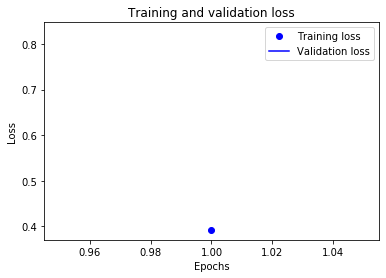

In [32]:
loss = history.history['loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,accuracy,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

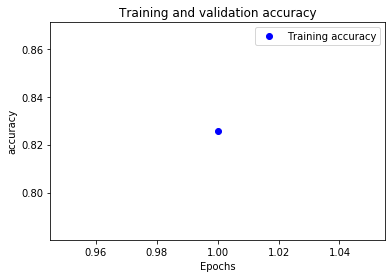

In [34]:
accuracy = history.history['accuracy']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# CNN model has shown overall accuracy of 82 perecent

In [35]:
history.history['accuracy']

[0.8256705]

# CNN model shown loss value is 0.38

In [36]:
history.history['loss'][-1]

0.39202396697239855

In [42]:
rnn

# Paramaters of the CNN model are changed for better accuracy

In [47]:
fpv = 5
t = time.time()
cnn_output = {}
# count1 = 0
for v in train_dir:
    t1 = time.time()
    folder_name = v.split('/')[5]
    cap = cv2.VideoCapture(v)
    count = 0
    while count < fpv:
        cap.set(cv2.CAP_PROP_POS_MSEC,((count * 30) + 5000))   
        ret, frame = cap.read()
        frame = cv2.resize(frame, (229, 229))
        x = image.img_to_array(frame)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)
        result = cnn_model.predict(x)
        if folder_name not in cnn_output.keys():
            cnn_output[folder_name] = []
        cnn_output[folder_name].append(list(result))
        count = count + 1
print('Total elapsed: ', time.time() - t)

Total elapsed:  1047.2050714492798


In [50]:
len(train_dir)

400

In [ ]:
learn.recorder.plot()

In [58]:
cnn_output

{'train_sample_videos\\aagfhgtpmv.mp4': [[array([0.92520446, 0.4301365 , 1.1427695 , ..., 1.8466938 , 1.1936063 ,
          0.09324795], dtype=float32)],
  [array([0.70944613, 0.39687467, 1.2399529 , ..., 2.1421773 , 1.5723761 ,
          0.        ], dtype=float32)],
  [array([0.9020346 , 0.38173926, 1.0520811 , ..., 2.1667373 , 2.006135  ,
          0.02313942], dtype=float32)],
  [array([0.86656165, 0.26055822, 0.83213454, ..., 1.589857  , 2.3787932 ,
          0.01222732], dtype=float32)],
  [array([0.86656165, 0.26055822, 0.83213454, ..., 1.589857  , 2.3787932 ,
          0.01222732], dtype=float32)]],
 'train_sample_videos\\aapnvogymq.mp4': [[array([0.89105743, 0.23639432, 0.32712266, ..., 0.05329672, 0.31350607,
          0.41025326], dtype=float32)],
  [array([0.8165041 , 0.20393063, 0.30601615, ..., 0.01889759, 0.34001327,
          0.30112058], dtype=float32)],
  [array([0.8738344 , 0.20666958, 0.38566777, ..., 0.07619268, 0.37372315,
          0.32947055], dtype=float32)],
 

In [57]:
cnn_model.predict(x)

array([[0.15844272, 0.5529749 , 0.5267723 , ..., 0.21906124, 0.30622798,
        0.28328246]], dtype=float32)

In [61]:
def preprocessing(video_path):
    try:
        faces = face_extractor.process_video(video_path)
        face_extractor.keep_only_best_face(faces)
        features = []
        for frame_data in faces:
            for face in frame_data["faces"]:
                face = make_square_image(isotropically_resize_image(face, input_size))
                features.append(np.asarray(face)[:,:,::-1])

        x = frames_per_video - np.array(features).shape[0]
        if(x == frames_per_video):
            return None, False

        if(x != 0):
            features = np.concatenate((np.zeros((x, 229, 229, 3)), np.array(features)))
        features = preprocess_input(np.array(features))
        return features, True
    
    except:
        return None, False

In [62]:
def predict_on_video(video_path):
    features, success = preprocessing(video_path)
    if(success == False):
        return 0.5
    return(rnn.predict(np.expand_dims(cnn_model.predict(np.array(features)), axis = 0))[0][1])

In [63]:
def predict_on_video_set(video_paths, output_list):
    output = []
    for v in video_paths: 
        output.append([v.split('/')[-1], predict_on_video(v)])
    return output

In [64]:
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames = frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [65]:
test_dir = glob.glob(input_path + 'test_videos/*.mp4')

In [66]:
t1 = time.time()
output_list = predict_on_video_set(test_dir, [])
print('Time taken (Preprocessing + Prediction): ', time.time() - t1)
df = pd.DataFrame(output_list, columns = ['filename', 'label'])

Time taken (Preprocessing + Prediction):  302.6994776725769


In [95]:
df.head()

,filename,label
0,test_videos\aassnaulhq.mp4,0.960093
1,test_videos\aayfryxljh.mp4,0.945127
2,test_videos\acazlolrpz.mp4,0.988654
3,test_videos\adohdulfwb.mp4,0.465923
4,test_videos\ahjnxtiamx.mp4,0.990661


In [98]:
df

,filename,label
0,test_videos\aassnaulhq.mp4,0.960093
1,test_videos\aayfryxljh.mp4,0.945127
2,test_videos\acazlolrpz.mp4,0.988654
3,test_videos\adohdulfwb.mp4,0.465923
4,test_videos\ahjnxtiamx.mp4,0.990661
...,...,...
395,test_videos\ztyvglkcsf.mp4,0.987158
396,test_videos\zuwwbbusgl.mp4,0.121230
397,test_videos\zxacihctqp.mp4,0.690090
398,test_videos\zyufpqvpyu.mp4,0.959646


In [78]:
test_dir = "C:/Users/tejru/Downloads/deepfake-detection-challenge/test_videos/"
test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])

In [80]:
from tqdm.notebook import tqdm

In [107]:
df_MetaData

,filename,label
0,aassnaulhq.mp4,0
1,aayfryxljh.mp4,0
2,acazlolrpz.mp4,0
3,adohdulfwb.mp4,0
4,ahjnxtiamx.mp4,0
...,...,...
395,ztyvglkcsf.mp4,0
396,zuwwbbusgl.mp4,0
397,zxacihctqp.mp4,0
398,zyufpqvpyu.mp4,0


In [108]:
df

,filename,label
0,test_videos\aassnaulhq.mp4,0.960093
1,test_videos\aayfryxljh.mp4,0.945127
2,test_videos\acazlolrpz.mp4,0.988654
3,test_videos\adohdulfwb.mp4,0.465923
4,test_videos\ahjnxtiamx.mp4,0.990661
...,...,...
395,test_videos\ztyvglkcsf.mp4,0.987158
396,test_videos\zuwwbbusgl.mp4,0.121230
397,test_videos\zxacihctqp.mp4,0.690090
398,test_videos\zyufpqvpyu.mp4,0.959646


# Segregated the predicted value videos into real and fake with a cutoff value of 0.5

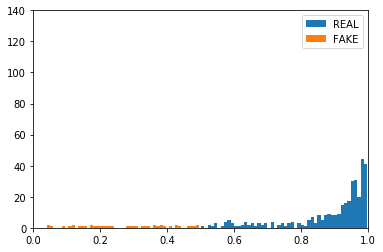

In [73]:
df_Real =df[df.label>0.5]
df_Fake =df[df.label<0.5]

data = list(df_Real.label)
count = np.histogram(data)[0]
plt.hist(data,50)

data = list(df_Fake.label)
count = np.histogram(data)[0]
plt.hist(data,50)

plt.legend(['REAL', 'FAKE'])

plt.axis([0,1,0,140])
plt.show()

In [165]:
df_MetaData = pd.read_csv('C:/Users/tejru/Downloads/sample_submission (1).csv')

In [166]:
print(len(df))

400


In [167]:
ara = df_MetaData.label

In [168]:
df.shape

(400, 2)

In [169]:
pred = df.label

In [170]:
tempData = pd.DataFrame({'Name': df.filename ,'actual': ara, 'predicted' : pred})

In [171]:
def logLoss(data):
    loss = 0.0
    actual = data['actual']
    predicted =  data['predicted']
    total = len(actual)
    for i in range(total):
        loss += ((1.0  * actual[i]) * np.log(predicted[i]) + (1.0 * (1 - actual[i])) * np.log(1 - predicted[i]))
    #print(loss)
    loss = (-1.0 * loss) / (1.0 * total)
    #print("Loss: ")
    #print(loss)
    return loss

# Combined the ground truth values with the prediction values.

In [172]:
tempData.shape
print(tempData)
loss = logLoss(tempData)
print("Loss: ")
print(loss)

                           Name  actual  predicted
0    test_videos\aassnaulhq.mp4       1   0.960093
1    test_videos\aayfryxljh.mp4       0   0.945127
2    test_videos\acazlolrpz.mp4       0   0.988654
3    test_videos\adohdulfwb.mp4       0   0.465923
4    test_videos\ahjnxtiamx.mp4       1   0.990661
..                          ...     ...        ...
395  test_videos\ztyvglkcsf.mp4       0   0.987158
396  test_videos\zuwwbbusgl.mp4       0   0.121230
397  test_videos\zxacihctqp.mp4       0   0.690090
398  test_videos\zyufpqvpyu.mp4       0   0.959646
399  test_videos\zzmgnglanj.mp4       0   0.952335

[400 rows x 3 columns]
Loss: 
1.364999000120014


In [173]:
df_MetaData

,filename,label
0,aassnaulhq.mp4,1
1,aayfryxljh.mp4,0
2,acazlolrpz.mp4,0
3,adohdulfwb.mp4,0
4,ahjnxtiamx.mp4,1
...,...,...
395,ztyvglkcsf.mp4,0
396,zuwwbbusgl.mp4,0
397,zxacihctqp.mp4,0
398,zyufpqvpyu.mp4,0


In [174]:
ara.unique

<bound method Series.unique of 0      1
1      0
2      0
3      0
4      1
      ..
395    0
396    0
397    0
398    0
399    0
Name: label, Length: 400, dtype: int64>

In [175]:
pred

0      0.960093
1      0.945127
2      0.988654
3      0.465923
4      0.990661
         ...   
395    0.987158
396    0.121230
397    0.690090
398    0.959646
399    0.952335
Name: label, Length: 400, dtype: float64

#  Comparision of individual video ground truth value with the predicted value.

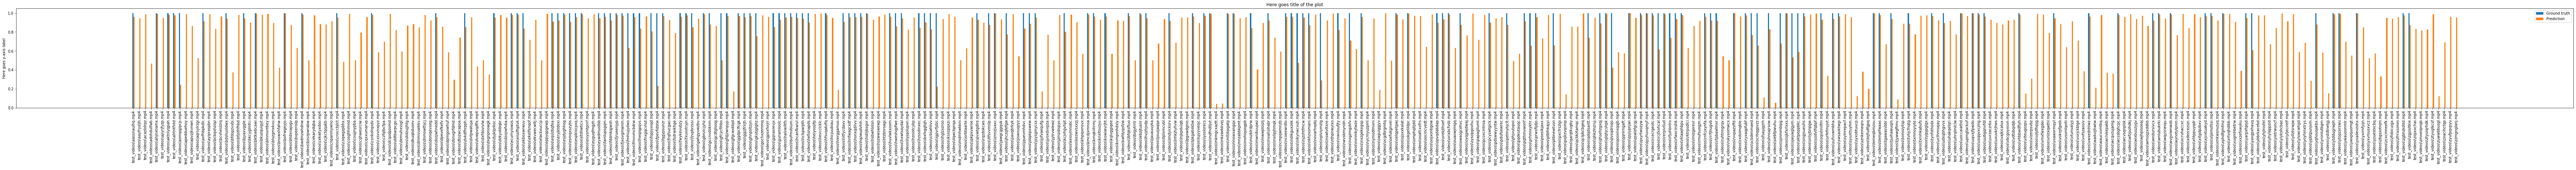

In [176]:

ind = np.arange(len(ara))
bluebar = ara
orangebar = pred
#print(bluebar)
#print(orangebar)
plt.figure(figsize = (125, 5))
width = 0.2
plt.bar(ind, bluebar , width, label='Ground truth')
plt.bar(ind + width, orangebar, width, label='Prediction')
names = tempData.Name
plt.ylabel('Here goes y-axis label')
plt.title('Here goes title of the plot')
plt.xticks(ind + width/2,(names), rotation = 'vertical')

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()


In [162]:
tempData

,Name,actual,predicted
0,test_videos\aassnaulhq.mp4,1.000000,0.960093
1,test_videos\aayfryxljh.mp4,0.000000,0.945127
2,test_videos\acazlolrpz.mp4,0.468954,0.988654
3,test_videos\adohdulfwb.mp4,0.000000,0.465923
4,test_videos\ahjnxtiamx.mp4,1.000000,0.990661
...,...,...,...
395,test_videos\ztyvglkcsf.mp4,0.000000,0.987158
396,test_videos\zuwwbbusgl.mp4,0.000000,0.121230
397,test_videos\zxacihctqp.mp4,0.136363,0.690090
398,test_videos\zyufpqvpyu.mp4,0.551943,0.959646
